UPDATE: Normalizing data
UPDATE: One-Hot Encoding data
Epoch 1/100
66/66 [==============================] - 14s 176ms/step - loss: 25.0389 - accuracy: 0.2638 - val_loss: 2.0455 - val_accuracy: 0.4363
Epoch 2/100
66/66 [==============================] - 5s 78ms/step - loss: 13.4438 - accuracy: 0.5415 - val_loss: 1.6599 - val_accuracy: 0.5567
Epoch 3/100
66/66 [==============================] - 7s 100ms/step - loss: 9.4273 - accuracy: 0.6103 - val_loss: 1.5412 - val_accuracy: 0.5807
Epoch 4/100
66/66 [==============================] - 9s 139ms/step - loss: 8.3187 - accuracy: 0.6731 - val_loss: 1.4402 - val_accuracy: 0.6179
Epoch 5/100
66/66 [==============================] - 10s 152ms/step - loss: 7.0520 - accuracy: 0.7043 - val_loss: 1.4140 - val_accuracy: 0.6329
Epoch 6/100
66/66 [==============================] - 8s 124ms/step - loss: 6.9220 - accuracy: 0.7211 - val_loss: 1.3844 - val_accuracy: 0.6309
Epoch 7/100
66/66 [==============================] - 8s 120ms/step - loss: 6.2243 - 

66/66 [==============================] - 10s 145ms/step - loss: 2.8841 - accuracy: 0.8492 - val_loss: 1.2585 - val_accuracy: 0.6881
Epoch 58/100
66/66 [==============================] - 9s 142ms/step - loss: 2.7242 - accuracy: 0.8607 - val_loss: 1.2312 - val_accuracy: 0.6921
Epoch 59/100
66/66 [==============================] - 9s 140ms/step - loss: 2.6005 - accuracy: 0.8655 - val_loss: 1.2354 - val_accuracy: 0.6820
Epoch 60/100
66/66 [==============================] - 10s 148ms/step - loss: 3.0959 - accuracy: 0.8487 - val_loss: 1.2536 - val_accuracy: 0.7011
Epoch 61/100
66/66 [==============================] - 12s 183ms/step - loss: 2.5579 - accuracy: 0.8616 - val_loss: 1.2598 - val_accuracy: 0.6901
Epoch 62/100
66/66 [==============================] - 12s 178ms/step - loss: 2.7488 - accuracy: 0.8679 - val_loss: 1.2365 - val_accuracy: 0.6891
Epoch 63/100
66/66 [==============================] - 11s 162ms/step - loss: 2.6907 - accuracy: 0.8633 - val_loss: 1.3032 - val_accuracy: 0.6710


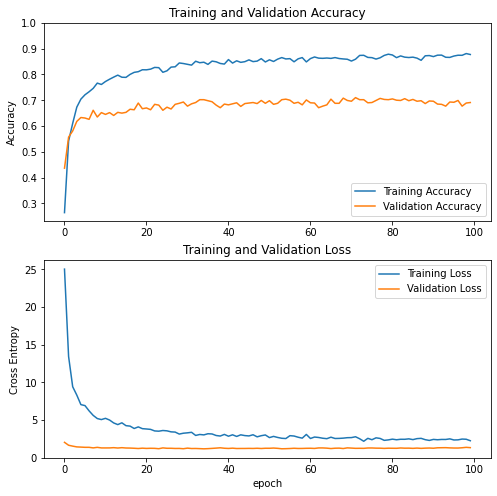

In [5]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

data_path = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD"
def load_data(dataset):
    images = []
    classes = []
    rows = pd.read_csv(dataset)
    rows = rows.sample(frac=1).reset_index(drop=True)
    for i, row in rows.iterrows():
        img_class = row["ClassId"]
        img_path = row["Path"]
        image = os.path.join(data_path, img_path)
        image = cv2.imread(image)
        image_rs = cv2.resize(image, (32, 32), 3)
        R, G, B = cv2.split(image_rs)
        img_r = cv2.equalizeHist(R)
        img_g = cv2.equalizeHist(G)
        img_b = cv2.equalizeHist(B)
        new_image = cv2.merge((img_r, img_g, img_b))
        if i % 500 == 0:
            print(f"loaded: {i}")
        images.append(new_image)
        classes.append(img_class)
    X = np.array(images)
    y = np.array(classes)
    
    return (X, y)
        
epochs = 100
learning_rate = 0.001
batch_size = 64

#####Run this part for the first time and save the pre-processed data. So you do not have to process it every time
#train_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD/TSRD Train Complete.csv"
#test_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD/TSRD Test Complete.csv"
#(train_X, train_Y) = load_data(train_data)
#(test_X, test_Y) = load_data(test_data)
#np.save('TSRD_trainX',train_X)
#np.save('TSRD_trainY',train_Y)
#np.save('TSRD_testX',test_X)
#np.save('TSRD_testY',test_Y)

train_X = np.load('TSRD_trainX.npy', allow_pickle=True)
test_X = np.load('TSRD_testX.npy', allow_pickle=True)
train_Y = np.load('TSRD_trainY.npy', allow_pickle=True)
test_Y = np.load('TSRD_testY.npy', allow_pickle=True)
print("UPDATE: Normalizing data")
trainX = train_X.astype("float32") / 255.0
testX = test_X.astype("float32") / 255.0
print("UPDATE: One-Hot Encoding data")
num_labels = len(np.unique(train_Y))
trainY = to_categorical(train_Y, num_labels)
testY = to_categorical(test_Y, num_labels)

class_totals = trainY.sum(axis=0)
class_weights = class_totals.max() / class_totals
class_weight_dict = dict(enumerate(class_weights))

data_aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.15,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
vertical_flip=False)

base_model = tf.keras.models.load_model('output/trafficsignnet.model')
optimizer = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs))

model = Sequential()
for layer in base_model.layers[:-1]:
    model.add(layer)
model.add(Dense(58, activation='softmax',name = 'output'))

for layer in model.layers[:-1]:
    layer.trainable = False # freeze the layer

initial_layer1_weights_values = model.layers[0].get_weights()

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
fit = model.fit(
    data_aug.flow(trainX, trainY, batch_size=batch_size), 
    epochs=epochs,
    validation_data=(testX, testY),
    class_weight=class_weight_dict,
    verbose=1)

#final_layer1_weights_values = model.layers[0].get_weights()
#check if layer[0] has changed during the training, the other layers may be checked in a similar way
#np.testing.assert_allclose(         
    #initial_layer1_weights_values[0], final_layer1_weights_values[0]
#)
#np.testing.assert_allclose(
    #initial_layer1_weights_values[1], final_layer1_weights_values[1]
#)


acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']

loss = fit.history['loss']
val_loss = fit.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [6]:
np.save('GtoC_Transfer_Learning_1', [acc,loss,val_acc,val_loss])

UPDATE: Normalizing data
UPDATE: One-Hot Encoding data
Epoch 1/100
66/66 [==============================] - 13s 119ms/step - loss: 20.9399 - accuracy: 0.3561 - val_loss: 1.8803 - val_accuracy: 0.5035
Epoch 2/100
66/66 [==============================] - 10s 149ms/step - loss: 9.6651 - accuracy: 0.6338 - val_loss: 1.7620 - val_accuracy: 0.5607
Epoch 3/100
66/66 [==============================] - 10s 149ms/step - loss: 6.4360 - accuracy: 0.7223 - val_loss: 1.4636 - val_accuracy: 0.6058
Epoch 4/100
66/66 [==============================] - 13s 190ms/step - loss: 5.5567 - accuracy: 0.7535 - val_loss: 1.4183 - val_accuracy: 0.6359
Epoch 5/100
66/66 [==============================] - 21s 315ms/step - loss: 4.4103 - accuracy: 0.7897 - val_loss: 1.3934 - val_accuracy: 0.6439
Epoch 6/100
66/66 [==============================] - 34s 506ms/step - loss: 3.7129 - accuracy: 0.8158 - val_loss: 1.3423 - val_accuracy: 0.6720
Epoch 7/100
66/66 [==============================] - 30s 454ms/step - loss: 3.37

66/66 [==============================] - 10s 153ms/step - loss: 0.5117 - accuracy: 0.9683 - val_loss: 1.9220 - val_accuracy: 0.6600
Epoch 58/100
66/66 [==============================] - 12s 180ms/step - loss: 0.6680 - accuracy: 0.9592 - val_loss: 1.3231 - val_accuracy: 0.7643
Epoch 59/100
66/66 [==============================] - 14s 214ms/step - loss: 0.4408 - accuracy: 0.9679 - val_loss: 1.1781 - val_accuracy: 0.7763
Epoch 60/100
66/66 [==============================] - 14s 218ms/step - loss: 0.5753 - accuracy: 0.9664 - val_loss: 1.3426 - val_accuracy: 0.7573
Epoch 61/100
66/66 [==============================] - 14s 213ms/step - loss: 1.1901 - accuracy: 0.9564 - val_loss: 2.0759 - val_accuracy: 0.6489
Epoch 62/100
66/66 [==============================] - 16s 240ms/step - loss: 0.7845 - accuracy: 0.9470 - val_loss: 1.8375 - val_accuracy: 0.6780
Epoch 63/100
66/66 [==============================] - 14s 217ms/step - loss: 1.2601 - accuracy: 0.9439 - val_loss: 2.2741 - val_accuracy: 0.614

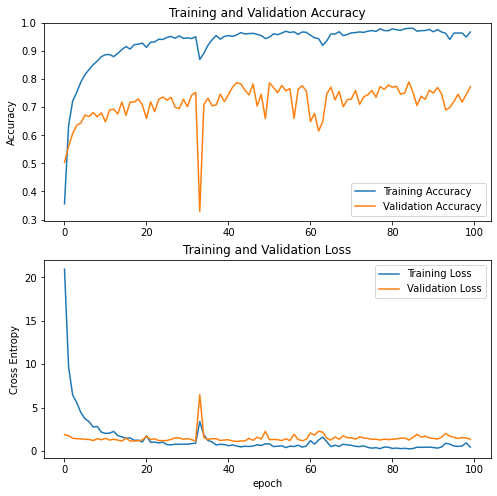

In [8]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

data_path = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD"
def load_data(dataset):
    images = []
    classes = []
    rows = pd.read_csv(dataset)
    rows = rows.sample(frac=1).reset_index(drop=True)
    for i, row in rows.iterrows():
        img_class = row["ClassId"]
        img_path = row["Path"]
        image = os.path.join(data_path, img_path)
        image = cv2.imread(image)
        image_rs = cv2.resize(image, (32, 32), 3)
        R, G, B = cv2.split(image_rs)
        img_r = cv2.equalizeHist(R)
        img_g = cv2.equalizeHist(G)
        img_b = cv2.equalizeHist(B)
        new_image = cv2.merge((img_r, img_g, img_b))
        if i % 500 == 0:
            print(f"loaded: {i}")
        images.append(new_image)
        classes.append(img_class)
    X = np.array(images)
    y = np.array(classes)
    
    return (X, y)
        
epochs = 100
learning_rate = 0.001
batch_size = 64

#####Run this part for the first time and save the pre-processed data. So you do not have to process it every time
#train_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD/TSRD Train Complete.csv"
#test_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD/TSRD Test Complete.csv"
#(train_X, train_Y) = load_data(train_data)
#(test_X, test_Y) = load_data(test_data)
#np.save('TSRD_trainX',train_X)
#np.save('TSRD_trainY',train_Y)
#np.save('TSRD_testX',test_X)
#np.save('TSRD_testY',test_Y)

train_X = np.load('TSRD_trainX.npy', allow_pickle=True)
test_X = np.load('TSRD_testX.npy', allow_pickle=True)
train_Y = np.load('TSRD_trainY.npy', allow_pickle=True)
test_Y = np.load('TSRD_testY.npy', allow_pickle=True)
print("UPDATE: Normalizing data")
trainX = train_X.astype("float32") / 255.0
testX = test_X.astype("float32") / 255.0
print("UPDATE: One-Hot Encoding data")
num_labels = len(np.unique(train_Y))
trainY = to_categorical(train_Y, num_labels)
testY = to_categorical(test_Y, num_labels)

class_totals = trainY.sum(axis=0)
class_weights = class_totals.max() / class_totals
class_weight_dict = dict(enumerate(class_weights))

data_aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.15,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
vertical_flip=False)

base_model = tf.keras.models.load_model('output/trafficsignnet.model')
optimizer = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs))

model = Sequential()
for layer in base_model.layers[:-1]:
    model.add(layer)
model.add(Dense(58, activation='softmax',name = 'output'))

# retrain everything
#for layer in model.layers[:-1]:
    #layer.trainable = False # freeze the layer
#initial_layer1_weights_values = model.layers[0].get_weights()

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
fit = model.fit(
    data_aug.flow(trainX, trainY, batch_size=batch_size), 
    epochs=epochs,
    validation_data=(testX, testY),
    class_weight=class_weight_dict,
    verbose=1)

#final_layer1_weights_values = model.layers[0].get_weights()
#check if layer[0] has changed during the training, the other layers may be checked in a similar way
#np.testing.assert_allclose(         
    #initial_layer1_weights_values[0], final_layer1_weights_values[0]
#)
#np.testing.assert_allclose(
    #initial_layer1_weights_values[1], final_layer1_weights_values[1]
#)


acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']

loss = fit.history['loss']
val_loss = fit.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

np.save('GtoC_Transfer_Learning_15', [acc,loss,val_acc,val_loss])

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

#data_path = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD"
#def load_data(dataset):
    #images = []
    #classes = []
    #rows = pd.read_csv(dataset)
    #rows = rows.sample(frac=1).reset_index(drop=True)
    #for i, row in rows.iterrows():
        #img_class = row["ClassId"]
        #img_path = row["Path"]
        #image = os.path.join(data_path, img_path)
        #image = cv2.imread(image)
        #image_rs = cv2.resize(image, (32, 32), 3)
        #R, G, B = cv2.split(image_rs)
        #img_r = cv2.equalizeHist(R)
        #img_g = cv2.equalizeHist(G)
        #img_b = cv2.equalizeHist(B)
        #new_image = cv2.merge((img_r, img_g, img_b))
        #if i % 500 == 0:
            #print(f"loaded: {i}")
        #images.append(new_image)
        #classes.append(img_class)
    #X = np.array(images)
    #y = np.array(classes)
    
    #return (X, y)
        
epochs = 100
learning_rate = 0.001
batch_size = 64

#####Run this part for the first time and save the pre-processed data. So you do not have to process it every time
#train_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD/TSRD Train Complete.csv"
#test_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD/TSRD Test Complete.csv"
#(train_X, train_Y) = load_data(train_data)
#(test_X, test_Y) = load_data(test_data)
#np.save('TSRD_trainX',train_X)
#np.save('TSRD_trainY',train_Y)
#np.save('TSRD_testX',test_X)
#np.save('TSRD_testY',test_Y)

train_X = np.load('TSRD_trainX.npy', allow_pickle=True)
test_X = np.load('TSRD_testX.npy', allow_pickle=True)
train_Y = np.load('TSRD_trainY.npy', allow_pickle=True)
test_Y = np.load('TSRD_testY.npy', allow_pickle=True)
print("UPDATE: Normalizing data")
trainX = train_X.astype("float32") / 255.0
testX = test_X.astype("float32") / 255.0
print("UPDATE: One-Hot Encoding data")
num_labels = len(np.unique(train_Y))
trainY = to_categorical(train_Y, num_labels)
testY = to_categorical(test_Y, num_labels)

class_totals = trainY.sum(axis=0)
class_weights = class_totals.max() / class_totals
class_weight_dict = dict(enumerate(class_weights))

data_aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.15,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
vertical_flip=False)

base_model = tf.keras.models.load_model('output/trafficsignnet.model')
optimizer = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs))

model = Sequential()
for layer in base_model.layers[:-1]:
    model.add(layer)
model.add(Dense(58, activation='softmax',name = 'output'))

for layer in model.layers[:-7]:
    layer.trainable = False # freeze the layer

#initial_layer1_weights_values = model.layers[0].get_weights()

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
fit = model.fit(
    data_aug.flow(trainX, trainY, batch_size=batch_size), 
    epochs=epochs,
    validation_data=(testX, testY),
    class_weight=class_weight_dict,
    verbose=1)

UPDATE: Normalizing data
UPDATE: One-Hot Encoding data
Epoch 1/100
66/66 [==============================] - 9s 126ms/step - loss: 21.8699 - accuracy: 0.3612 - val_loss: 1.8296 - val_accuracy: 0.5206
Epoch 2/100
66/66 [==============================] - 6s 93ms/step - loss: 9.9278 - accuracy: 0.6415 - val_loss: 1.5015 - val_accuracy: 0.5827
Epoch 3/100
66/66 [==============================] - 7s 100ms/step - loss: 6.7170 - accuracy: 0.7177 - val_loss: 1.3606 - val_accuracy: 0.6279
Epoch 4/100
66/66 [==============================] - 6s 97ms/step - loss: 5.3513 - accuracy: 0.7580 - val_loss: 1.3377 - val_accuracy: 0.6359
Epoch 5/100
66/66 [==============================] - 6s 93ms/step - loss: 4.6615 - accuracy: 0.7830 - val_loss: 1.3701 - val_accuracy: 0.6499
Epoch 6/100
66/66 [==============================] - 6s 97ms/step - loss: 4.2872 - accuracy: 0.8024 - val_loss: 1.4128 - val_accuracy: 0.6570
Epoch 7/100
66/66 [==============================] - 7s 107ms/step - loss: 3.8701 - accura